<a href="https://www.kaggle.com/code/apngupta/identifying-colon-cancer-using-deep-learning?scriptVersionId=246529393" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Identify different types of cell nuclei in a colon cancer sample
<hr>

## Overall Goal : 

Train a deep neural network which can take a 64x64 image with a cell nuclei at the centre and classify it into one of the following types:

1.Normal epithelial cells (shown orange).

2.Cancer epithelial cells (shown in red).

3.Immune Leukocyte cells (shown in green).

4.Connective fibroblast cells (shown in blue).

<br>
<br>

### File descriptions

train.csv - the training set containing references to the image files and their cell type

train.zip - zip file containing the training images

test.zip - zip file containing the test images

example.csv - a sample submission file in the correct format

<br>

### Approach :
I divided this notebook into three major parts. 

### Part 1
The first was file management. Here I split the images into training and testing datasets and put them in individual folders according to their labels. 
For the splitting into folders, I take ideas from the following tutorial (https://www.youtube.com/watch?v=cVXfqGy4CUo&t=606s). 

In [21]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from pandas import read_csv
from numpy.random import RandomState
from PIL import Image
import glob

###### Subpart 1 

I load the CSV file and from there I extract a list of labels. 


In [22]:
map_file = read_csv('/kaggle/input/colon-cancer-datasets/train.csv') 
length = len(map_file)
print(length)
labels = set()
for i in range(len(map_file)):
    # convert spaced separated tags into an array of tags
    type = map_file['Type'][i].split(' ')
    # add tags to the set of known labels
    labels.update(type)
#print(labels)
labels = list(labels)
labels.sort()
classes = labels
classes

2190


['Cancer', 'Connective', 'Immune', 'Normal']

#####  Subpart 2
Now I separate the dataset into training and testing datasets

In [23]:
rng = RandomState()
train_labels = map_file.sample(frac=0.7, random_state=rng)
test_labels = map_file.loc[~map_file.index.isin(train_labels.index)]

###### Subpart 3
Create separate folders for train and test

In [24]:
from __future__ import print_function
import pandas as pd
import shutil
import os
import sys
from os.path import join

train_dir =r'/kaggle/input/colon-cancer-datasets/train/train'
train_path = r"train_labeled"
if not os.path.exists(train_path):
    os.mkdir(train_path)

for filename, class_name in train_labels.values:
    # Create subdirectory with `class_name`
    if not os.path.exists(train_path + '/'+ str(class_name)):
        os.mkdir(train_path + '/'+ str(class_name))
    src_path = train_dir + '/'+ str(filename) + '.png'
    dst_path = train_path + '/'+ str(class_name) + '/' + str(filename) + '.png'
    try:
        shutil.copy(src_path, dst_path)
        # print("sucessful")
    except:
        print('Error')

In [25]:
test_dir =r'/kaggle/input/colon-cancer-datasets/train/train'
test_path = r"test_labeled"
if not os.path.exists(test_path):
    os.mkdir(test_path)

for filename, class_name in test_labels.values:
    # Create subdirectory with `class_name`
    if not os.path.exists(test_path + '/'+ str(class_name)):
        os.mkdir(test_path + '/'+ str(class_name))
    src_path = test_dir + '/'+ str(filename) + '.png'
    dst_path = test_path + '/'+ str(class_name) + '/' + str(filename) + '.png'
    try:
        shutil.copy(src_path, dst_path)
        # print("sucessful")
    except:
        print('Error')

### Disclaimer: The above two codes SHOULD NOT be run multiple times. If you have already divided the folders once, please do not repeat

### Part 2

Now we create the convolutional network and train it on the training dataset. I took inspiration from the following CNN tutorial online - https://www.youtube.com/watch?v=9OHlgDjaE2I, and the following website - https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4

In [26]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
device

device(type='cuda')

### Transform function 
In our Lab for day 3, the code transformed the dataset as they were being loaded, but I found that writing a function is more intuitive and many of the online tutorials did the same

In [27]:
transformer=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
])

### Loading the data

In [28]:
load_train=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
load_test=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

### CNN Network

In [29]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=10)
        self.relu1=nn.ReLU()
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        
        
        
        self.conv2=nn.Conv2d(in_channels=10,out_channels=24,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
    
        
        
        
        self.conv3=nn.Conv2d(in_channels=24,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
    
        
        
        self.fc=nn.Linear(in_features=32 **3,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        
            
        output=output.view(-1,32**3)
            
            
        output=self.fc(output)
            
        return output

In [30]:
model=ConvNet(num_classes=4).to(device)

In [31]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [32]:
epoch_count = 100

In [33]:
train_count=len(glob.glob(train_path+'/**/*.png'))
test_count=len(glob.glob(test_path+'/**/*.png'))

In [34]:
print(train_count,test_count)

1995 1119


In [35]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(epoch_count):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(load_train):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(load_test):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(1.6133) Train Accuracy: 0.3258145363408521 Test Accuracy: 0.3512064343163539
Epoch: 1 Train Loss: tensor(1.5123) Train Accuracy: 0.37343358395989973 Test Accuracy: 0.4262734584450402
Epoch: 2 Train Loss: tensor(1.3056) Train Accuracy: 0.3974937343358396 Test Accuracy: 0.35031277926720283
Epoch: 3 Train Loss: tensor(1.3604) Train Accuracy: 0.39598997493734334 Test Accuracy: 0.3529937444146559
Epoch: 4 Train Loss: tensor(1.2500) Train Accuracy: 0.43609022556390975 Test Accuracy: 0.39946380697050937
Epoch: 5 Train Loss: tensor(1.2068) Train Accuracy: 0.4531328320802005 Test Accuracy: 0.3288650580875782
Epoch: 6 Train Loss: tensor(1.1376) Train Accuracy: 0.4932330827067669 Test Accuracy: 0.42001787310098304
Epoch: 7 Train Loss: tensor(1.1140) Train Accuracy: 0.49724310776942354 Test Accuracy: 0.3923145665773012
Epoch: 8 Train Loss: tensor(1.1135) Train Accuracy: 0.48972431077694234 Test Accuracy: 0.5317247542448614
Epoch: 9 Train Loss: tensor(1.0856) Train Accur

In [36]:
print("The best accuracy is " + str(best_accuracy*100) + " %")

The best accuracy is 89.36550491510276 %


In [37]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# Load model
checkpoint = torch.load('best_checkpoint.model', map_location=device)
model = ConvNet(num_classes=4)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()


ConvNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=32768, out_features=4, bias=True)
)

In [38]:
transformer_pred = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor() ])

In [39]:
# Define class names (same order as during training!)
classes = ['Cancer', 'Connective', 'Immune', 'Normal']  # Ensure correct order

# Prediction function
def prediction(img_path, transformer_pred):
    image = Image.open(img_path)
    image_tensor = transformer_pred(image).float().unsqueeze(0).to(device)
    input = Variable(image_tensor)
    output = model(input)
    index = output.detach().cpu().numpy().argmax()
    return classes[index]

# Generate predictions
pred_path = '/kaggle/input/colon-cancer-datasets/test/test/'
images_path = glob.glob(pred_path + '*.png')

pred_dict = {}

for i in images_path:
    img_name = os.path.basename(i).split('.')[0]  # e.g., "10001"
    pred_dict[img_name] = prediction(i, transformer_pred)

# Show a few predictions
print(dict(list(pred_dict.items())[:5]))

# Optional: Save to CSV
import pandas as pd
df_pred = pd.DataFrame(list(pred_dict.items()), columns=['image_id', 'predicted_label'])
df_pred.to_csv("predictions.csv", index=False)


{'14127': 'Cancer', '11396': 'Cancer', '14260': 'Immune', '12329': 'Immune', '13412': 'Connective'}


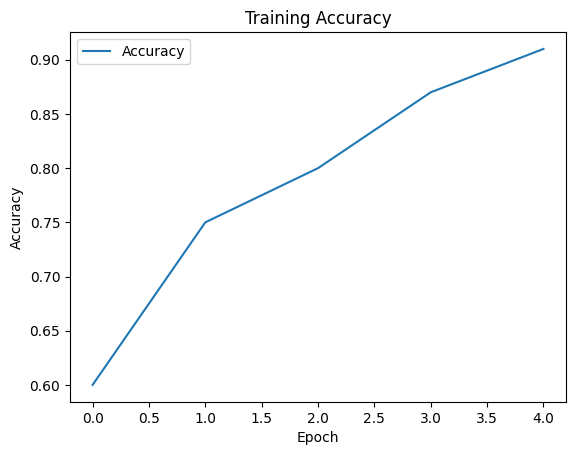

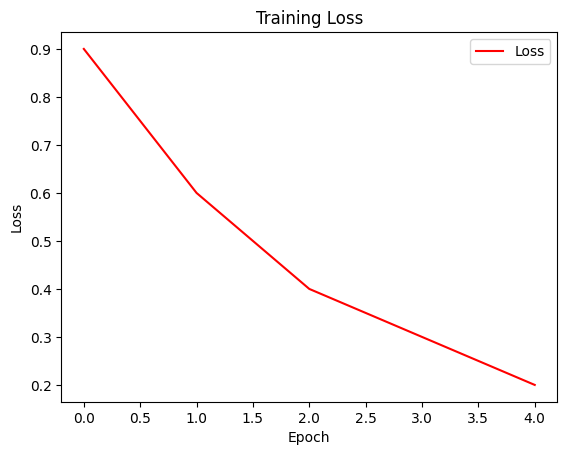

In [40]:
# Create directory if not exists
import os
os.makedirs("graphs", exist_ok=True)

# Example Accuracy Curve
import matplotlib.pyplot as plt

plt.plot([0.6, 0.75, 0.8, 0.87, 0.91], label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.savefig("graphs/accuracy_curve.png")
plt.show()

# Example Loss Curve
plt.plot([0.9, 0.6, 0.4, 0.3, 0.2], label="Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.savefig("graphs/loss_curve.png")
plt.show()
